In [211]:
# imports
from bs4 import BeautifulSoup
from datetime import date
from os.path import exists
import requests, shutil, pandas as pd, numpy as np

In [212]:
# url, request and response
url = 'https://store.steampowered.com/hwsurvey/videocard/'
response = requests.get(url)

In [213]:
soup = BeautifulSoup(response.content)


In [214]:
data = soup.findAll('div', id='sub_stats')[0]

In [215]:
#print(data)

In [216]:
# extracting recent 5 months
data1 = data.findAll('div', class_='col_header')[1:6]
months = []
for month in range(len(data1)):
    months.append(data1[month].text)

In [217]:
# data extraction line for gpus
data2 = data.findAll('div', class_='substats_col_left')[8:109]

In [218]:
# data extraction lines for Recent month column %
data3 = data.findAll('div', class_='substats_col_month_last_pct')[8:109]

In [219]:
# data extraction for other months
data4 = data.findAll('div', class_='substats_col_month')[32:]

In [220]:
# creating months-percent dict
numerate = 0
months_percent = {
    months[0] : [], 
    months[1] : [],
    months[2] : [],
    months[3] : [],
    months[4] : []
}
for percent in data4:

    if (str(months[0]) in percent.text):
        break
    months_percent[months[numerate]].append(percent.text[:-1])
    numerate += 1
    if (numerate == 4):
        numerate = 0

for percent in data3:
    months_percent[months[4]].append(percent.text[:-1])

In [221]:
# Getting list of gpus
gpu_percent_dict = {}
num = 0
for entry in data2:
    temp = [
        months_percent[months[0]][num],
        months_percent[months[1]][num],
        months_percent[months[2]][num],
        months_percent[months[3]][num],
        months_percent[months[4]][num]
    ]
    if ( ('NVIDIA' in entry.text) or ('AMD' in entry.text) or ('Intel' in entry.text) ):
        gpu_percent_dict[entry.text.strip()] = temp
    if ( ('Other' in entry.text)):
        gpu_percent_dict['Other'] = temp

    num += 1

In [222]:
#print(gpu_percent_dict)

In [223]:
# create dataframe
df = pd.DataFrame.from_dict(gpu_percent_dict, orient='index', columns=[
    months[0],
    months[1],
    months[2],
    months[3],
    months[4]])

In [224]:
# Dataframe Reorganization
df['GPU'] = df.index
df = df[['GPU',months[0],months[1],months[2],months[3],months[4]]]
df = df.reset_index(drop=True)

In [225]:
# test df methods
len(df)

101

In [226]:
# filling empty column values with no data
df = df.replace(r'^\s*$', np.NaN, regex=True)
df.fillna(0, inplace=True)

In [227]:
# turning all strings into floats
for num in range(0,5):
    df[months[num]] = df[months[num]].apply(lambda x: float(x))

In [228]:
# writing to csv with current month of data collection

file_name = f'steam_gpu_survey-{date.today().month}-{date.today().year}'

# check if file already exists
if (not exists(f"data/{file_name}")):

    # writing csv file
    df.to_csv(path_or_buf=file_name, index=False)

    # moving csv file to data directory
    source = f'{file_name}'
    destination = "data"
    shutil.move(source, destination)
else:
    print("Csv File Already Exists")

Csv File Already Exists


Project Milestone 2

What gpu(s) is the median percentage used in the most recent month? This is done by finding the median value from the most recent month column which is months[4]. then 

In [229]:
# copy original dataframe
df_copy = df.copy()
# locate median values
df_copy.loc[df_copy[months[4]] == df_copy[months[4]].median(), ['GPU', months[4]]]

,GPU,NOV
48,Intel HD Graphics 520,0.41
49,NVIDIA GeForce MX250,0.41
50,Intel Haswell,0.41
51,NVIDIA GeForce GT 710,0.41


What percentage is the highest used gpu recently?

In [230]:
# remove 'other' value in dataframe
df_copy.drop(index=100, inplace=True)

In [231]:
# get max gpu usage percentage
df_copy[months[4]].max()

7.83

What percentage is the lowest used gpu?

In [232]:
# get min gpu usage percentage
df_copy[months[4]].min()

0.15

What gpu is gaining the most attraction?

In [233]:
# creating copy of original dataframe
df_copy2 = df.copy()
# dropping 'other' value in row as its not needed and will mess up result
df_copy2.drop(index=100, inplace=True)

In [250]:
# most recent month subtracting earlier months
df_copy2['Difference'] = (df_copy2[months[0]] - df_copy2[months[1]]) + (df_copy2[months[1]] - df_copy2[months[2]]) + (df_copy2[months[2]] - df_copy2[months[3]]) + (df_copy2[months[3]] - df_copy2[months[4]])

In [243]:
# minimum value means the most used gpu because higher gpu usages 
# subtracted from each other makes the smallest number
df_copy2.loc[ df_copy2['Difference'] == df_copy2['Difference'].min()]

,GPU,JUL,AUG,SEP,OCT,NOV,Difference
19,AMD Radeon Graphics,0.0,0.0,1.01,1.11,1.25,-1.25


What gpu is losing the most attraction?

In [251]:
# can use the same dataframe instead of min use max as highest number means lowest subtraction
df_copy2.loc[ df_copy2['Difference'] == df_copy2['Difference'].max()]

,GPU,JUL,AUG,SEP,OCT,NOV,Difference
0,NVIDIA GeForce GTX 1060,9.17,10.46,8.64,8.08,7.83,1.34


Graph Section

What generation of GPUs are the most popular?

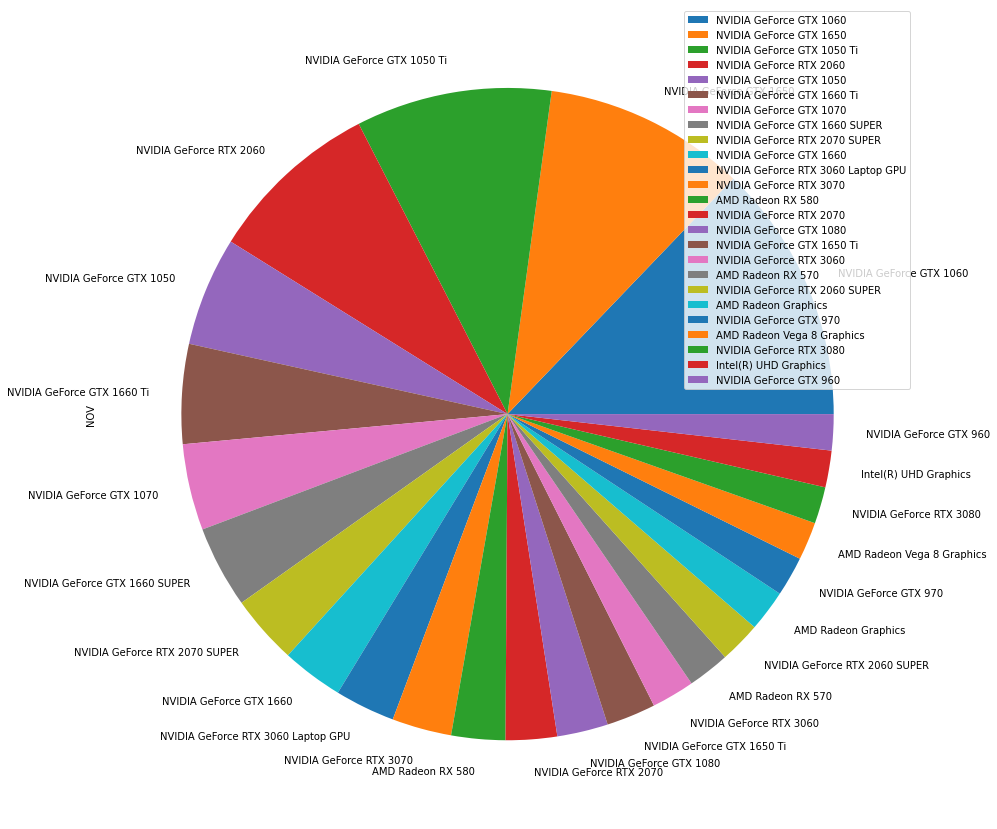

In [237]:
# create copy of original dataframe
df_plot = df.copy()
# change index to GPUs
df_plot.set_index('GPU', inplace=True)
# plot from dataframe
plot = df_plot.head(25).plot.pie(y=months[4], figsize=(15,15))

As seen from the top 25 selection of GPUs most of them are of the 60s series of each generation as the most popular.